# Tarea 3: Los K-vecinos 

## Introducción

<img src="images/vecinos.png" width="400">

Los $K$-vecinos es un método clásico y muy sencillo para hacer clasificación de datos, que se basa en predecir la etiqueta de un dato basado en las etiquetas de los datos de entrenamiento que más se le parecen. La siguiente figura describe graficamente los tres pasos del algoritmo

<img src="images/algoritmo.png" width="600">

En este caso es clave definir una noción de distancia entre los ejemplos y también especificar un valor adecuado para $K$, la cantidad de vecinos que influyen en la predicción.

## Formalismo matemático

Sea una base de datos $E = \{(x_j, y_j), j=1, \ldots, N\}$, con $N$ ejemplos donde $x_j \in \mathbb{R}^{D}$ es un atributo d-dimensional e $y_j \in \{0, 1, 2, \ldots, C-1\}$ son sus etiquetas de clase. Sea ahora una segunda base de datos $T = \{(z_i), i=1, \ldots, M\}$ con $M$ ejemplos donde $z_i \in \mathbb{R}^{D}$ es un atributo d-dimensional. Esta base de datos no tiene etiquetas. El objetivo es clasificar los ejemplos de $T$ en base a las etiquetas de los $K$ ejemplos más cercanos de la base de datos $E$


El algoritmo para clasificar el i-esimo elemento de Z es

**Paso 1** Calculamos la distancia entre $z_i$ y cada elemento de $E$ usando

$$
d(z_i, x_j) = \left ( \sum_{d=1}^D  |z_{id} - x_{jd}|^p \right)^{1/p}
$$

que se conoce como [distancia de Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance). Para el caso $p=2$ se recupera la clásica distancia euclidiana.

**Paso 2** Buscamos las $k$ tuplas $(x_k^{(i)}, y_k^{(i)})$ con menor distancia a $z_i$

**Paso 3** Seleccionamos la clase de $z_i$ según

$$
\text{arg}\max_{c=0, 1, \ldots} \sum_{k=1}^K \frac{\mathbb{1}(c=y^{(i)}_k)}{d(z_i, x^{(i)}_k)}
$$

donde 

$$
\mathbb{1}(a=b) = \begin{cases} 1 & \text{si } a=b \\ 0 &  \text{si } a\neq b \end{cases}
$$

se conoce como función indicadora. Esta versión particular del algoritmo se conoce como clasificador de $k$ vecinos ponderado, ya que una menor distancia (mayor cercanía) aumenta el peso del voto

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **23:59 del Martes 20 de Julio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Instrucciones de la actividad

- (1pt) Considere la implementación "ingenua" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto
    - Use la función adjunta `create_data` para crear un conjunto de `N=1000` datos
    - Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`
    - Reporte sus resultados y comente sobre los cuellos de botella del algoritmo
- (2pt) Implemente una nueva versión de la función `KNN`
    - Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`
    - Muestre que obtiene el mismo resultado que la versión original
    - Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$
- (2pt) Usando la nueva versión de `KNN` y el conjunto de `N=1000` datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$
- (1pt) Evalue su mejor clasificador en el conjunto $T$ y haga un reporte completo de resultados que incluya curvas ROC y las métricas vistas en el curso. Muestre una gráfica de la frontera de decisión de su clasificador en el rango $[(-2,2), (-2,2)]$

**Justifique adecuadamente todas sus decisiones de diseño**

A continuación se muestra una gráfica con los datos a utilizar en esta tarea

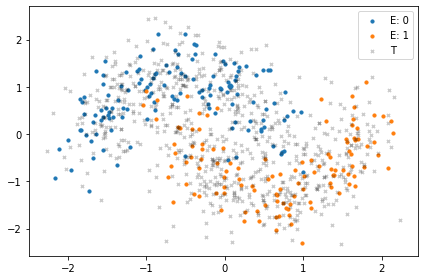

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();


### 1. Mediciones de KNN

#### 1.1 Utilizando la magia %timeit

Podemos medir el tiempo promedio de un script, función o expresión de Python de forma conveniente usando la magia timeit. Esta magia se basa en el módulo estándar de Python timeit.
En este caso, se ejecuta 4 veces la función, realizando 2 loops en cada iteración y especificamos que el resultado tenga una precisión de 8 dígitos. 

In [2]:
timeitResult = %timeit -r4 -n2 -p8 -o Z_Y_1 = KNN(x,y,z)

2.0851903 s ± 25.622657 ms per loop (mean ± std. dev. of 4 runs, 2 loops each)


#### 1.2 Utilizando la magia %prun 

Se debe instalar SnakeViz

    conda install snakeviz

Esto retorna una tabla con las siguientes filas
- ncalls: Número de veces que se llama la función
- tottime: Tiempo total en dicha función (sin contar subfunciones)
- percall: ttime/ncalls
- cumtime: Tiempo total en dicha función y sus subfunciones (tiempo de función recursiva)
- percall: cumtime/ncalls

(En general, el tiempo total es mayor que el que medimos con time y timeit. Esto se debe al overhead de prun)


In [3]:
%prun -s cumtime Z_Y_1 = KNN(x,y,z)

In [ ]:
%load_ext snakeviz
%snakeviz KNN(x,y,z) #-t

#### 1.3 Utilizando la magia lprun

Debes instalar la extensión externa "line_profiler"

    conda install line_profiler


Esta magia nos permite estudiar el tiempo de ejecución de cada linea de nuestro código por separado.

Ejecutarla nos levantará una pestaña con una tabla que tiene una fila por linea de código y las siguientes columnas

- Line: Número de la linea dentro del código fuente

- Hits: La cantidad de veces que se llama a esa linea

- Time: Tiempo total de dicha linea

- Per hit: Tiempo total dividido la cantidad de llamadas



In [5]:
%load_ext line_profiler
%lprun -f KNN KNN(x,y,z)

De las mediciones realizadas podemos concluir lo siguiente:


### 2. KNN en Cython

Debes instalar cython

    conda install cython


In [3]:
%load_ext cython

con esto tendremos disponible la magia de bloque %%cython

Un bloque donde se use esta magia acepta lenguaje cython y se compila al ejecutarlo. Luego podremos llamar las funciones de ese bloque desde bloques regulares de Python

Si surgen errores de compulación estos aparecen como la salida del bloque. Notar que este bloque está “desconectado” del resto del notebook, por lo que debe tener sus propios import

La magia tiene las siguientes opciones

    -a, (annotate) retorna un profile linea a linea indicando con amarillo las llamadas a CPython (mientras más llamadas más lento es nuestro código)
    -+, Usar C++ en lugar de C
    -c, Argumentos de compilación
    -l, librerías para linkear a nuestro código
    -L, directorio con librerías
    -I, directorio con cabeceras (include)

In [2]:
# Requerido para Mac OS X

#import os
#os.environ["CC"] = "/usr/local/opt/llvm/bin/clang"

In [15]:
%%cython -l m --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
import numpy as np
cimport numpy as npc
from cython.parallel import prange

cdef extern from "math.h" nogil:
    double fabs(double)
    double pow(double,double)

@cython.boundscheck(False)
@cython.initializedcheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cpdef npc.ndarray CKNN(double [:,::1] X, long [:] Y, double [:,::1] Z, unsigned char k=5, double p = 2.0):
    
    # Clases
    cdef long [:] c = np.unique(Y) 
    
    cdef unsigned short C = c.shape[0] # Número de clases
    cdef unsigned short N = X.shape[0] # Número de muestras conocidas
    cdef unsigned short D = X.shape[1] # Número de dimensiones
    cdef unsigned short M = Z.shape[0] # Número de muestras a entrenar
        
    # Exponente inv
    cdef double expo = 1.0/p;
    
    # Indices de los k mas cercanos
    cdef unsigned short [:,::1] kInds = np.zeros((M,k),dtype='uint16')
    
    # Distancias de los k mas cercanos
    cdef double [:,::1] kDists = np.full((M,k),1.7976931348623157e+308,dtype='float64')
    
    # Indice de la distancia más grande ( dentro de las k más pequeñas )
    cdef unsigned short [:] maxDistIndex = np.zeros(M,dtype='uint16')
    
    # Indice de la clase ganadora
    cdef unsigned short [:] winnerClassIndex = np.zeros(M,dtype='uint16')
    cdef double [:] winnerClassDist = np.zeros(M,dtype='float64')
    
    # Variable para almacenar suma de distancias inversas por clase ( para decidir clase )
    cdef double [:,::1] cRes = np.zeros((M,C),dtype='float64')
    
    # Variable temporal para calcular distancia
    cdef double [:] dist = np.zeros(M,dtype='float64')
    
    # Resultados
    cdef unsigned char [:] YZ = np.zeros(M,dtype='uint8')
    
    # Indices
    cdef short i,j,d,l = 0
    
    # Loop cada elemento de Z
    with nogil:
        for i in prange(M,num_threads=12):

            # Loop cada elemento de X
            for j in range(N):

                # Calcula distancia
                dist[i] = 0.0
                for d in range(D):
                    dist[i] += pow(fabs(Z[i,d] - X[j,d]),p)
                dist[i] = pow(dist[i],expo)

                # Si la distancia es menor que la mayor en kDists
                if dist[i] < kDists[i,maxDistIndex[i]]:

                    # Reemplaza el valor
                    kDists[i,maxDistIndex[i]] = dist[i]

                    # Guarda el índice del elemento X actual
                    kInds[i,maxDistIndex[i]] = j

                    # Vuelve a buscar el mayor actual en kDists
                    dist[i] = 0
                    for l in range(k):
                        if kDists[i,l] > dist[i]:
                            dist[i] = kDists[i,l]
                            maxDistIndex[i] = l

            # Calcula la cercanía ponderada por distancia de cada clase
            for d in range(k):

                # Suponiendo que los nombres de las clases siempre son 0,1,...,C-1
                cRes[i,Y[kInds[i,d]]] += 1.0/kDists[i,d]

            # Busca la clase ganadora
            for d in range(C):
                if cRes[i,d] > winnerClassDist[i]:
                    winnerClassDist[i] = cRes[i,d]
                    winnerClassIndex[i] = d

            # Guarda la clase ganadora en el arreglo
            YZ[i] = c[winnerClassIndex[i]]
                        
            
    return YZ.base
            

In [16]:
%timeit -r10 -n10 CKNN(x,y,z)

4.15 ms ± 158 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [11]:
%timeit -r2 -n2 KNN(x,y,z)

1.81 s ± 19.3 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [38]:
from sklearn.neighbors import KNeighborsClassifier

def SKLEARN(x,y,z):
    knn = KNeighborsClassifier(n_neighbors = 5,weights='distance',p=2,)
    knn.fit(x,y)
    knn.predict(z)

In [60]:
%timeit -r10 -n10 SCIKIT(x,y,z)

2.22 ms ± 238 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [61]:
CKNN(x,y,z)

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,

In [63]:
KNN(x,y,z).astype("uint8")

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,